# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1. Data Cleaning

In [2]:
# Portfolio dataframe
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
portfolio.shape

(10, 6)

**Tasks**
* Split the channels into several columns
* Split offer_type into several columns
* change id column name to offer_id

In [5]:
portfolio_clean = portfolio.copy()

In [6]:
# Create dummy columns for the channels column
dummy_channels = pd.get_dummies(portfolio_clean.channels.apply(pd.Series).stack(), prefix="channel").sum(level=0)
portfolio_clean = pd.concat([portfolio_clean, dummy_channels], axis=1, sort=False)

In [7]:
portfolio_clean.drop(columns='channels', inplace=True)

In [8]:
# Create dummy columns for the offer_type column
dummy_offer_type = pd.get_dummies(portfolio_clean.offer_type, prefix="offer")
portfolio_clean = pd.concat([portfolio_clean, dummy_offer_type], axis=1, sort=False)

In [9]:
portfolio_clean.drop(columns='offer_type', inplace=True)

In [10]:
# Change column name
portfolio_clean.rename(columns={'id':'offer_id'}, inplace=True)

In [11]:
portfolio_clean.head()

,difficulty,duration,offer_id,reward,channel_email,channel_mobile,channel_social,channel_web,offer_bogo,offer_discount,offer_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0


In [12]:
# Profile dataframe
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [13]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [14]:
profile.shape

(17000, 5)

**Tasks**
* Fix the date.
* Split gender column into dummy columns
* Change the column name id to customer_id. 
* There are 2,175 missing values in the gender and income columns

In [15]:
profile_clean = profile.copy()

In [16]:
# Transform date from int to datetime
profile_clean.became_member_on = profile_clean.became_member_on.apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [17]:
# Handle the Null values in columns
# Since all the Null values seem to be associated to the same rows, create a dummy column
# that contains a 1 if the data is missing, 0 otherwise.
print((profile_clean.age == 118).sum())
print((profile_clean.gender.isnull()).sum())
print((profile_clean.income.isnull()).sum())

2175
2175
2175


In [18]:
profile_clean['valid'] = (profile_clean.age == 118).astype(int)

In [19]:
profile_clean.groupby('valid').count()

,age,became_member_on,gender,id,income
valid,,,,,
0,14825,14825,14825,14825,14825
1,2175,2175,0,2175,0


In [20]:
# Create dummy columns for the gender column
dummy_gender = pd.get_dummies(profile_clean.gender, prefix="gender")
profile_clean = pd.concat([profile_clean, dummy_gender], axis=1, sort=False)
profile_clean.drop(columns='gender', inplace=True)

In [21]:
# Change the name of id column to customer_id
profile_clean.rename(columns={'id':'customer_id'}, inplace=True)

In [22]:
profile_clean.head()

,age,became_member_on,customer_id,income,valid,gender_F,gender_M,gender_O
0,118,2017-02-12,68be06ca386d4c31939f3a4f0e3dd783,NaN,1,0,0,0
1,55,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,0,1,0,0
2,118,2018-07-12,38fe809add3b4fcf9315a9694bb96ff5,NaN,1,0,0,0
3,75,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,1,0,0
4,118,2017-08-04,a03223e636434f42ac4c3df47e8bac43,NaN,1,0,0,0


In [23]:
# Transcript dataframe
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [24]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [25]:
transcript.shape

(306534, 4)

* Split value in several columns for offers and transactions
* Split event column into sevelar columns
* Change column name person to customer_id

In [57]:
transcript_clean = transcript.copy()

In [58]:
# Split event into several dummy columns
transcript_clean.event = transcript_clean.event.str.replace(' ','_')
dummy_event = pd.get_dummies(transcript_clean.event, prefix="event")
transcript_clean = pd.concat([transcript_clean, dummy_event], axis=1, sort=False)
transcript_clean.drop(columns='event', inplace=True)

In [63]:
# Get the offer_id data from the value column
transcript_clean['offer_id'] = [[*v.values()][0] if [*v.keys()][0] in ['offer id', 'offer_id'] else None
                                for v in transcript_clean.value]

In [64]:
transcript_clean[transcript_clean.event_offer_completed==1].head()

,person,time,value,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,1,0,0,0,2906b810c7d4411798c6938adc9daaa5
12672,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,1,0,0,0,fafdcd668e3743c1bb461111dcafc2a4
12679,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
12692,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,1,0,0,0,ae264e3637204a6fb9bb56bc8210ddfd
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,1,0,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [65]:
transcript_clean[transcript_clean.event_offer_received==1].head()

,person,time,value,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [66]:
transcript_clean[transcript_clean.event_offer_viewed==1].head()

,person,time,value,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id
12650,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,0,1,0,f19421c1d4aa40978ebb69ca19b0e20d
12651,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,0,1,0,5a8bc65990b245e5a138643cd4eb9837
12652,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0
12653,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,0,1,0,ae264e3637204a6fb9bb56bc8210ddfd
12655,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,0,1,0,5a8bc65990b245e5a138643cd4eb9837


In [67]:
# Get the transaction amount data from the value column
transcript_clean['amount'] = [np.round([*v.values()][0], decimals=2) if [*v.keys()][0] == 'amount' else None
                              for v in transcript_clean.value]

In [68]:
transcript_clean[transcript_clean.event_transaction==1].head()

,person,time,value,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001},0,0,0,1,None,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56},0,0,0,1,None,34.56
12659,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23},0,0,0,1,None,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51},0,0,0,1,None,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97},0,0,0,1,None,18.97


In [69]:
transcript_clean.drop(columns='value', inplace=True)

In [70]:
# Change the name of person column to customer_id
transcript_clean.rename(columns={'person':'customer_id'}, inplace=True)

In [71]:
transcript_clean.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


Let's check if all users in the profile are actually present in the transcript

In [72]:
# Check for active and inactive customers
active_customers = set(profile_clean.customer_id).intersection(set(transcript_clean.customer_id))
inactive_customers = set(profile_clean.customer_id).difference(set(transcript_clean.customer_id))

In [73]:
len(active_customers)

17000

In [74]:
len(inactive_customers)

0

Let's merge all the dataframes into one for analysis. This dataframe will have several NaN values in places where that piece of data is not needed. 

In [75]:
trans_prof = pd.merge(transcript_clean, profile_clean, on='customer_id', how="left")

In [76]:
df = pd.merge(trans_prof, portfolio_clean, on='offer_id', how='left')

In [77]:
trans_prof.shape

(306534, 15)

In [78]:
transcript_clean.shape

(306534, 8)

In [79]:
df.shape

(306534, 25)

In [80]:
df[df.event_offer_completed == 1].head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,age,became_member_on,...,difficulty,duration,reward,channel_email,channel_mobile,channel_social,channel_web,offer_bogo,offer_discount,offer_informational
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,1,0,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,42,2016-01-17,...,10.0,7.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
12672,fe97aa22dd3e48c8b143116a8403dd52,0,1,0,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,39,2017-12-17,...,10.0,10.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
12679,629fc02d56414d91bca360decdfa9288,0,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,52,2018-06-05,...,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
12692,676506bad68e4161b9bbaffeb039626b,0,1,0,0,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,37,2017-05-15,...,10.0,7.0,10.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,1,0,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,48,2015-09-03,...,10.0,5.0,10.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


## Analysis

Let's check the total amount that the experiment ran

In [114]:
df.time.max() / 24

29.75

Experiment ran for a full month

Let's start analyzing the purchases alone

In [94]:
df[df.event_transaction == 1].amount.describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

In [100]:
perc99 = df[df.event_transaction == 1].amount.quantile(0.99)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


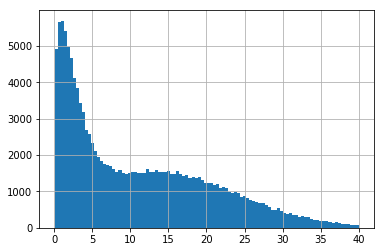

In [101]:
df[df.event_transaction == 1][df.amount <= perc99].amount.hist(bins=100)

In [111]:
total_expense_customer = df[df.event_transaction == 1].groupby('customer_id').amount.sum()
total_expense_customer.describe()

count    16578.000000
mean       107.096874
std        126.393939
min          0.050000
25%         23.682500
50%         72.410000
75%        150.937500
max       1608.690000
Name: amount, dtype: float64

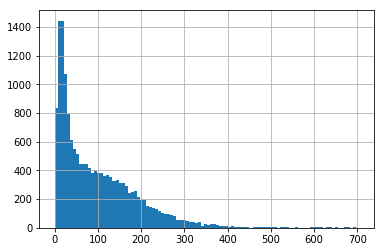

In [109]:
perc99_percust = total_expense_customer.quantile(0.99)
total_expense_customer[total_expense_customer <= perc99_percust].hist(bins=100)